NOTES It can be the data set chosen to be the solution to PART I or a different one. Design the network:

The student should decide the values of relevant parameters : 
1. Percentage of data for testing
2. How many layers of LSTM?
3. Number of neurons in each LSTM  layer?
4. Any DropOut layer? 
5. If with DropOut layer: the percentage to drop
6. Length of the time-series input sequence
7. Batch size for training (NOTES : Batch size for testing and forecasting must be ONE)
8. Number of epochs for training 

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
#sequential data reader

from tensorflow.keras.layers import LSTM
#Long short term memory

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
#Dense is a fully connected layer or FFNN(feedforward neural network).


In [3]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

### Data Set: Treasury interest yield (1/2/1990-12/30/2009)
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll

In [4]:
df_all = pd.read_csv("1990.csv")
df_all.tail(5)
#Adj close = the closing price excluded dividend and split effect

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
4999,12/24/2009,0.02,NaN,0.05,0.18,0.43,1.00,1.56,2.57,3.32,3.82,4.60,4.68
5000,12/28/2009,0.03,NaN,0.11,0.20,0.47,1.09,1.63,2.62,3.34,3.85,4.61,4.69
5001,12/29/2009,0.02,NaN,0.10,0.20,0.47,1.09,1.64,2.62,3.33,3.82,4.57,4.64
5002,12/30/2009,0.02,NaN,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.80,4.54,4.61
5003,12/31/2009,0.04,NaN,0.06,0.20,0.47,1.14,1.70,2.69,3.39,3.85,4.58,4.63


In [5]:
df_all.shape

(5004, 13)

In [296]:
df_all.dtypes

Date      object
1 Mo     float64
2 Mo     float64
3 Mo     float64
6 Mo     float64
1 Yr     float64
2 Yr     float64
3 Yr     float64
5 Yr     float64
7 Yr     float64
10 Yr    float64
20 Yr    float64
30 Yr    float64
dtype: object

In [297]:
df_all.describe()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,2105.000000,0.0,5001.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,4065.000000,4010.000000
mean,2.198304,NaN,3.881428,4.040923,4.187534,4.537030,4.754820,5.120602,5.384616,5.562682,5.646809,6.224519
std,1.618567,NaN,1.967405,1.974862,1.936733,1.895358,1.804245,1.644626,1.549959,1.447799,1.027790,1.341930
min,0.000000,NaN,0.010000,0.130000,0.260000,0.650000,0.880000,1.260000,1.590000,2.080000,2.860000,2.530000
25%,0.950000,NaN,2.210000,2.290000,2.547500,3.120000,3.460000,3.910000,4.150000,4.410000,4.840000,5.180000
50%,1.730000,NaN,4.440000,4.560000,4.650000,4.750000,4.805000,5.100000,5.390000,5.440000,5.520000,6.130000
75%,3.520000,NaN,5.200000,5.360000,5.560000,5.910000,6.040000,6.280000,6.450000,6.560000,6.420000,7.310000
max,5.270000,NaN,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


### Keep Only 1 Year Treasury bond yield and Filter Our All Other Attributes
This project focus on the 1 year treasury bond yield because this dataset has no na.

In [298]:
df = df_all.iloc[:,5:6]
# this will take only 1Yr to store at df
df.head()

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81


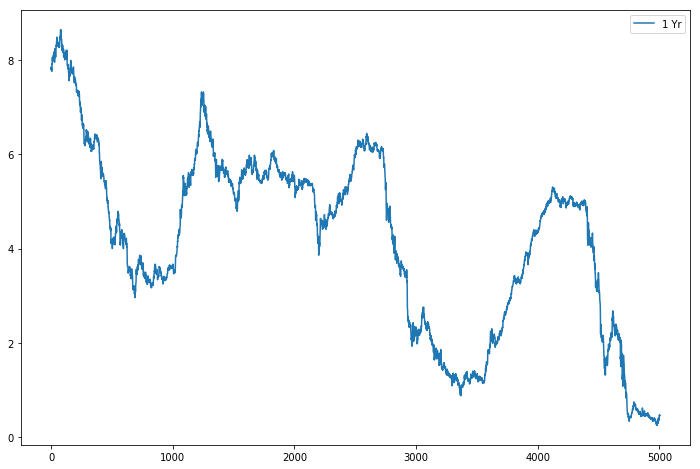

In [299]:
df.plot(figsize=(12,8))

### Lenght of Input Time Series - Number of input Time Steps

In [300]:
#Set the Lenght of the input sequence
length60 = 60

### Time series Dataset: Train/ test split

In [301]:
len(df)

5004

In [302]:
# set percentage of data used for testing
test_percent = 0.3
#30% of dataset is for testing

In [271]:
test_length = np.round(len(df)*test_percent)
test_length
#The test data points is 

1501.0

In [272]:
#testing dataset starts at the index
split_index = int(len(df)-test_length)
split_index

3503

In [273]:
data_train = df.iloc[:split_index]
data_test = df.iloc[split_index - length60 :]
#the last 60 data of the training dataset until the end of the data to test the model

In [274]:
data_train.head(5)

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81


In [275]:
data_test.head(5)
#3506 - 60 =  3446

,1 Yr
3443,1.15
3444,1.21
3445,1.21
3446,1.22
3447,1.21


### Normaliza Data(Scale it into the range [0,1])

In [276]:
scaler = MinMaxScaler()
scaler.fit(data_train)
normalized_train = scaler.transform(data_train)
normalized_test = scaler.transform(data_test)
#transform the value in normal[0,1]

### Create TimeseriesGenerate for Training

In [277]:
#Time series has 60 historical data point
batch_size32 = 32


train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length60, batch_size = batch_size32)
#TimeseriesGenerator(input,outputs, length, batch_size)


In [278]:
#This project generate times 3506 - 60 = 3406 
len(normalized_train)

3503

In [279]:
len(train_tsGenerator60)
#batch generated by time series generator from 4204
#last that left from generate sequnce processes
#This project generate 3446 times = 3506 - 60 
# 3446/32 each batch has 108 samples

108

In [280]:
X,y = train_tsGenerator60[0]
print(X)

[[[0.89304124]
  [0.89819588]
  [0.8943299 ]
  ...
  [0.95618557]
  [0.96262887]
  [0.96005155]]

 [[0.89819588]
  [0.8943299 ]
  [0.89046392]
  ...
  [0.96262887]
  [0.96005155]
  [0.96391753]]

 [[0.8943299 ]
  [0.89046392]
  [0.89304124]
  ...
  [0.96005155]
  [0.96391753]
  [0.96262887]]

 ...

 [[0.91108247]
  [0.92139175]
  [0.93170103]
  ...
  [0.9742268 ]
  [0.96907216]
  [0.96907216]]

 [[0.92139175]
  [0.93170103]
  [0.92912371]
  ...
  [0.96907216]
  [0.96907216]
  [0.96005155]]

 [[0.93170103]
  [0.92912371]
  [0.94845361]
  ...
  [0.96907216]
  [0.96005155]
  [0.94458763]]]


### Build Train and Test

In [281]:
n_features = 1
#feature has 1 preditor

In [282]:
#define the model
model = Sequential()

model.add(LSTM(units=50, activation='relu',return_sequences=True, input_shape=(length60,n_features)))
#return_sequences=True will return the value to next LSTM layer
#input_shape=(length60,n_features) = input demension is 2 demensions.
model.add(Dropout(0.2))
#dropout 20% of the all data

model.add(LSTM(units=50, activation='relu',return_sequences=True))
#learning funciton to fullfill the dropped data.
#return_sequences=True will return the value to next LSTM layer
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation='relu'))
#learning funciton to fullfill the dropped data.

model.add(Dense(1))

### Complie model

In [283]:
model.compile(optimizer = 'adam', loss ='mse')
#complie Adaptive Moment Estimation (adam) and loss function to monitor the model

model.summary()
#summmarize the model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
__________________________________________________

### Train(Fit) model Using fit_generator()

In [284]:
model.fit_generator(train_tsGenerator60, epochs=20)

Epoch 1/20
108/108 [==============================] - 24s 223ms/step - loss: 0.0337
Epoch 2/20
108/108 [==============================] - 17s 160ms/step - loss: 0.0017
Epoch 3/20
108/108 [==============================] - 18s 163ms/step - loss: 0.0016
Epoch 4/20
108/108 [==============================] - 18s 163ms/step - loss: 0.0014
Epoch 5/20
108/108 [==============================] - 17s 162ms/step - loss: 0.0020
Epoch 6/20
108/108 [==============================] - 17s 160ms/step - loss: 0.0021
Epoch 7/20
108/108 [==============================] - 17s 160ms/step - loss: 0.0013
Epoch 8/20
108/108 [==============================] - 17s 160ms/step - loss: 0.0013
Epoch 9/20
108/108 [==============================] - 17s 161ms/step - loss: 9.3086e-04
Epoch 10/20
108/108 [==============================] - 18s 162ms/step - loss: 0.0012
Epoch 11/20
108/108 [==============================] - 17s 160ms/step - loss: 0.0014
Epoch 12/20
108/108 [==============================] - 17s 160ms/step 

### Visualize the model

In [285]:
loss_history_keys = model.history.history.keys()

loss_history_keys

dict_keys(['loss'])

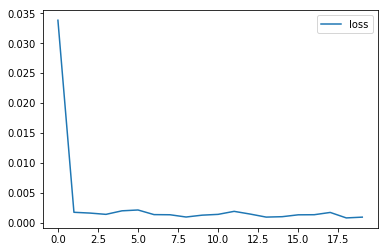

In [286]:
df_model_loss = pd.DataFrame(model.history.history)

df_model_loss.plot()

### prediction for Testing: Using TimeseriesGenerator

In [287]:
batch_size1 =1 
# In a timeserise batch has 1 dataset

test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length60, batch_size = batch_size1)
#TimeseriesGenerator(input,outputs, length, batch_size)

### Predict Future Data Points for Testing
### Create TimeriesGenerator for Testing

In [288]:
normalized_prediction = model.predict_generator(test_tsGenerator60)
# predict the time series
normalized_prediction
#1802 data point (predicted value)

array([[0.04337811],
       [0.0433842 ],
       [0.04340179],
       ...,
       [0.03833567],
       [0.0383748 ],
       [0.03841387]], dtype=float32)

In [303]:
len(normalized_prediction)

1501

In [304]:
prediction = scaler.inverse_transform(normalized_prediction)
#convert the predicted value to be true value
prediction_index =np.arange(3506,5006,step=1)
#3505 data poiints + 1501 data points in the testing data = 5006 data points

df_prediction = pd.DataFrame(data = prediction, index=prediction_index, columns=['Prediction'])
#index will predict from 4204 to 6006
df_prediction

,Prediction
3503,1.216614
3504,1.216661
3505,1.216798
3506,1.216949
3507,1.217079
...,...
4999,1.176979
5000,1.177213
5001,1.177485
5002,1.177788


### Visualization

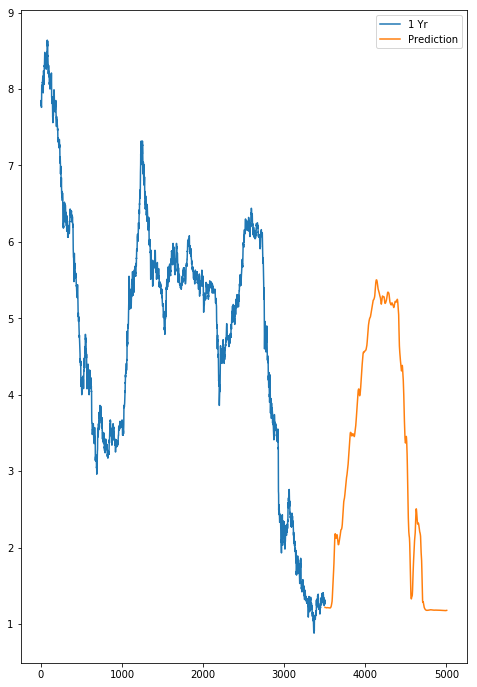

In [305]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(8,12))
# orange is predicted value
#blue is real value that train the dataset

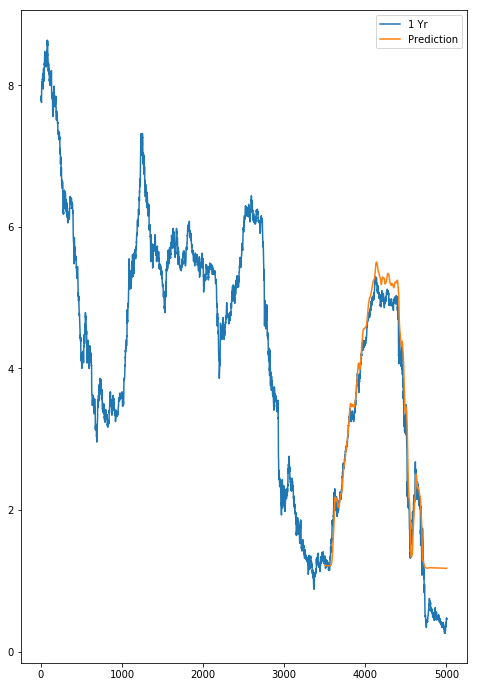

In [306]:
ax = df.plot()

df_prediction.plot(ax=ax, figsize=(8,12))
# orange is predicted value
#blue is real value

## Time Series Forecasting with LSTM
forecast the future should employ all the avaliable data Not split the data into training/testing

### Preprocesses Full Input Dataset

In [307]:
full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

### Create TimeSeriesGenerator for Forecasting

In [308]:
length60

60

In [309]:
# the batch =32
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length = length60, batch_size = batch_size32)

### Build, Complie, and Fit LSTM Model for Forecasting

In [310]:
model.fit_generator(forecast_tsGenerator, epochs = 10)

Epoch 1/10
155/155 [==============================] - 25s 158ms/step - loss: 8.6627e-04
Epoch 2/10
155/155 [==============================] - 25s 159ms/step - loss: 8.2629e-04
Epoch 3/10
155/155 [==============================] - 25s 160ms/step - loss: 0.0010
Epoch 4/10
155/155 [==============================] - 25s 162ms/step - loss: 8.3798e-04
Epoch 5/10
155/155 [==============================] - 25s 163ms/step - loss: 7.1469e-04
Epoch 6/10
155/155 [==============================] - 25s 160ms/step - loss: 0.0013
Epoch 7/10
155/155 [==============================] - 25s 158ms/step - loss: 7.8405e-04
Epoch 8/10
155/155 [==============================] - 25s 159ms/step - loss: 9.0454e-04
Epoch 9/10
155/155 [==============================] - 25s 159ms/step - loss: 7.3982e-04
Epoch 10/10
155/155 [==============================] - 25s 159ms/step - loss: 8.0596e-04


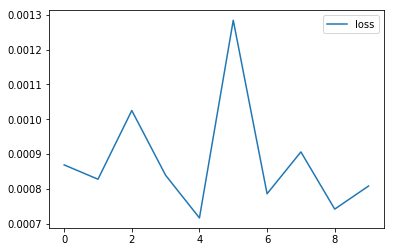

In [311]:
loss_history_keys = model.history.history.keys()

loss_history_keys
df_model_loss = pd.DataFrame(model.history.history)

df_model_loss.plot()

### Time Series Forecasting with LSTM Neural Network: (1/4/2010-12/31/2010)

In [335]:
forecast = []
periods = 252
# days business days (1/4/2010-12/31/2010)

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1,length60,n_features))
#The last 60 dataset is the first batch

for i in range(periods):
    #get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

### Invese to Transform Normalized Data Back into True Values

In [336]:
forecast = full_scaler.inverse_transform(forecast)
forecast

array([[0.39465696],
       [0.39550604],
       [0.39613647],
       [0.39654377],
       [0.39675292],
       [0.3968016 ],
       [0.39672982],
       [0.39657454],
       [0.39636705],
       [0.3961322 ],
       [0.3958886 ],
       [0.39564949],
       [0.39542358],
       [0.39521614],
       [0.39502981],
       [0.3948654 ],
       [0.39472241],
       [0.39459947],
       [0.39449494],
       [0.39440683],
       [0.39433309],
       [0.39427179],
       [0.39422119],
       [0.39417958],
       [0.3941456 ],
       [0.3941179 ],
       [0.39409554],
       [0.39407745],
       [0.39406293],
       [0.39405129],
       [0.39404206],
       [0.39403471],
       [0.39402892],
       [0.39402436],
       [0.39402082],
       [0.39401804],
       [0.3940159 ],
       [0.39401425],
       [0.39401301],
       [0.39401211],
       [0.39401144],
       [0.39401091],
       [0.39401055],
       [0.39401031],
       [0.39401017],
       [0.39401011],
       [0.39401006],
       [0.394

In [337]:
df

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81
...,...
4999,0.43
5000,0.47
5001,0.47
5002,0.45


### Create new timestamp index with pandas:07/01/20-12/15/2019

In [362]:
forecast_index = np.arange(5004,5255, step=1)

In [363]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index, columns=['Forecast'])
forecast_df

,Forecast
5004,0.394657
5005,0.395506
5006,0.396136
5007,0.396544
5008,0.396753
...,...
5251,0.394010
5252,0.394010
5253,0.394010
5254,0.394010


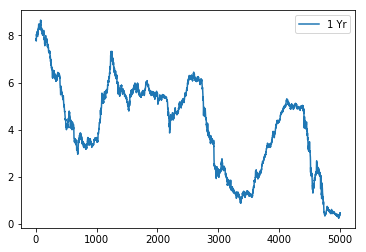

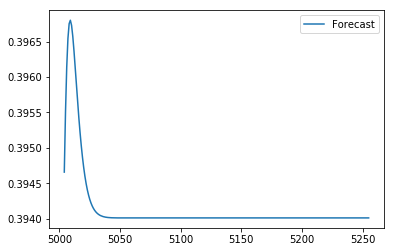

In [364]:
df.plot()
forecast_df.plot()

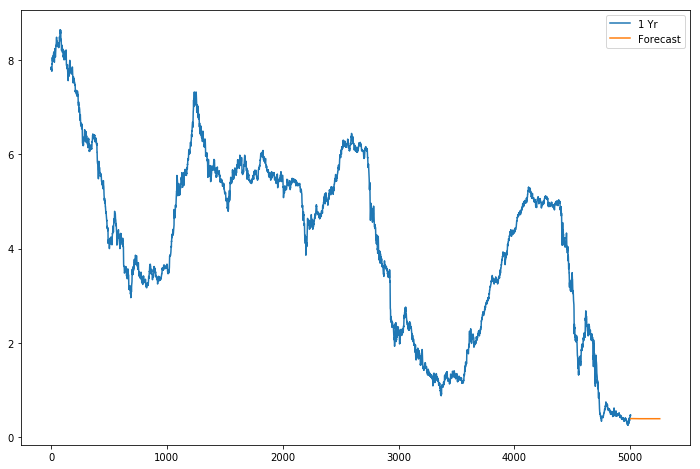

In [365]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize=(12,8))

In [366]:
dir_path_dataset_2 = 'prediction.csv'

In [367]:
df_all_predicting = pd.read_csv(dir_path_dataset_2)

In [368]:
df_all_predicting.head()

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,1/4/2010,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,1/5/2010,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,1/6/2010,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,1/7/2010,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,1/8/2010,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70


In [369]:
df_all_predicting = df_all_predicting.iloc[:,5:6]

In [370]:
df_all_predicting

,1 Yr
0,0.45
1,0.41
2,0.40
3,0.40
4,0.37
...,...
247,0.32
248,0.31
249,0.30
250,0.29


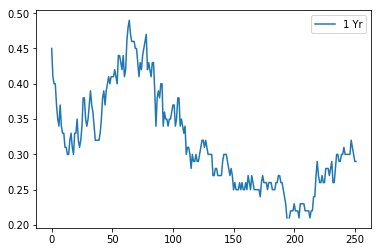

In [371]:
df_all_predicting.plot()

In [372]:
forecast_df['Forecast'].values

array([0.39465696, 0.39550604, 0.39613647, 0.39654377, 0.39675292,
       0.3968016 , 0.39672982, 0.39657454, 0.39636705, 0.3961322 ,
       0.3958886 , 0.39564949, 0.39542358, 0.39521614, 0.39502981,
       0.3948654 , 0.39472241, 0.39459947, 0.39449494, 0.39440683,
       0.39433309, 0.39427179, 0.39422119, 0.39417958, 0.3941456 ,
       0.3941179 , 0.39409554, 0.39407745, 0.39406293, 0.39405129,
       0.39404206, 0.39403471, 0.39402892, 0.39402436, 0.39402082,
       0.39401804, 0.3940159 , 0.39401425, 0.39401301, 0.39401211,
       0.39401144, 0.39401091, 0.39401055, 0.39401031, 0.39401017,
       0.39401011, 0.39401006, 0.39401003, 0.39401009, 0.39401006,
       0.39401008, 0.39401003, 0.39401006, 0.39401003, 0.39401006,
       0.39401006, 0.39401006, 0.39401008, 0.39401009, 0.39401013,
       0.39401013, 0.39401013, 0.39401013, 0.39401016, 0.39401014,
       0.39401016, 0.39401016, 0.39401016, 0.39401016, 0.39401016,
       0.39401016, 0.39401016, 0.39401016, 0.39401016, 0.39401

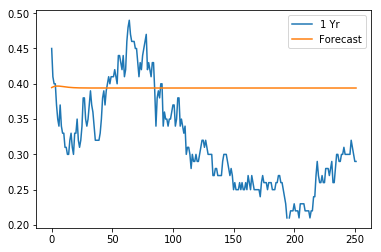

In [373]:
df_all_predicting['Forecast'] = forecast_df['Forecast'].values
df_all_predicting.plot()